In [18]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.2.0


In [19]:
data_root='/kaggle/input/sarscov2-ctscan-dataset'
path_positive_cases = os.path.join('/kaggle/input/sarscov2-ctscan-dataset/COVID')
path_negative_cases = os.path.join('/kaggle/input/sarscov2-ctscan-dataset/non-COVID')

In [20]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [21]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [22]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 1252
Total Negative Cases Covid19 images: 1229


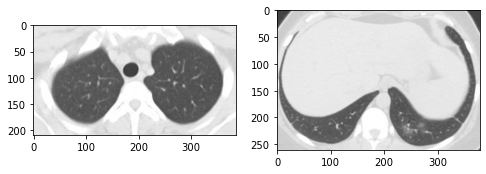

In [23]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [24]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [25]:
# Copy Images to test set

# seed random number generator
random.seed(237)
# define ratio of pictures used for testing 
test_ratio = 0.2


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

CT_COVID 250
CT_NonCOVID 245


In [26]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [27]:
total_train_covid = len(os.listdir('/kaggle/working/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/kaggle/working/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/kaggle/working/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/kaggle/working/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 1002
Train sets images Non COVID: 984
Test sets images COVID: 250
Test sets images Non COVID: 245


In [28]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import PIL
import matplotlib.pyplot as plt
import json
from IPython.display import Image as disp_image 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 

In [29]:
img_height = 256
img_width = 256
channels = 3
batch_size = 8
epochs = 10

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    './train',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'binary',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    './train',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'binary',
     subset = 'validation',
     shuffle=False)

test_set = train_datagen.flow_from_directory(
    './test',
     target_size = (img_height, img_width),
     batch_size = 1,
     shuffle = False,
     class_mode = 'binary')

print(training_set.class_indices)

Found 1590 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
{'CT_COVID': 0, 'CT_NonCOVID': 1}


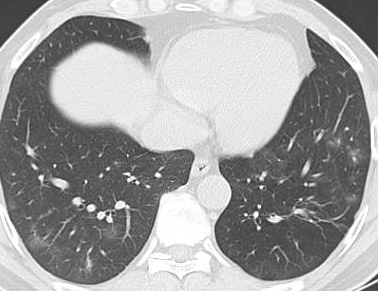

In [30]:
# Covid image example
from PIL import Image
img_files = os.listdir('train/CT_COVID')
img_path = img_files[np.random.randint(0,len(img_files))]

img = Image.open('train/CT_COVID/{}'.format(img_path))
img.thumbnail((500, 500))
display(img)

In [31]:
# NonCovid image example
img_files = os.listdir('train/CT_NonCOVID')
img_path = img_files[np.random.randint(0,len(img_files))]

img = cv2.imread('train/CT_NonCOVID/{}'.format(img_path))
#img.thumbnail((500, 500))
display(img)

array([[[ 65,  65,  65],
        [ 66,  66,  66],
        [ 67,  67,  67],
        ...,
        [ 72,  72,  72],
        [ 68,  68,  68],
        [ 66,  66,  66]],

       [[ 64,  64,  64],
        [ 64,  64,  64],
        [ 65,  65,  65],
        ...,
        [ 74,  74,  74],
        [ 66,  66,  66],
        [ 66,  66,  66]],

       [[ 64,  64,  64],
        [ 65,  65,  65],
        [ 65,  65,  65],
        ...,
        [110, 110, 110],
        [ 93,  93,  93],
        [ 83,  83,  83]],

       ...,

       [[216, 216, 216],
        [220, 220, 220],
        [223, 223, 223],
        ...,
        [223, 223, 223],
        [223, 223, 223],
        [209, 209, 209]],

       [[212, 212, 212],
        [215, 215, 215],
        [218, 218, 218],
        ...,
        [221, 221, 221],
        [208, 208, 208],
        [185, 185, 185]],

       [[213, 213, 213],
        [214, 214, 214],
        [215, 215, 215],
        ...,
        [205, 205, 205],
        [179, 179, 179],
        [154, 154, 154]]

In [32]:
# VGG16
model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, channels))



In [33]:
for layer in model.layers[:-5]:
    layer.trainable = False

top_model = Sequential()
top_model.add(model)
top_model.add(Flatten())
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

print(model.summary())
print(top_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [34]:
# Compile Model
top_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6),
                  metrics=['accuracy'])

# Save Model
history = top_model.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=epochs,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size)

# Save Model
top_model.save('covid_model.h5', save_format='h5')

Epoch 1/10
198/198 [==============================] - 865s 4s/step - loss: 0.5553 - accuracy: 0.7137 - val_loss: 0.5576 - val_accuracy: 0.7602
Epoch 2/10
  2/198 [..............................] - ETA: 5:53 - loss: 0.2560 - accuracy: 0.8750

KeyboardInterrupt: 

In [37]:
# Plot Accuracy and Loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'history' is not defined

In [38]:
# Model Performance on test set
test_pred = top_model.evaluate_generator(test_set,
                                        steps=test_set.n//batch_size,
                                        use_multiprocessing=False,
                                        verbose=1)

print('Test loss: ', test_pred[0])
print('Test accuracy: ', test_pred[1])

61/61 [==============================] - 21s 349ms/step - loss: 0.7506 - accuracy: 0.6393
Test loss:  0.7505500912666321
Test accuracy:  0.6393442749977112


495/495 [==============================] - 179s 361ms/step


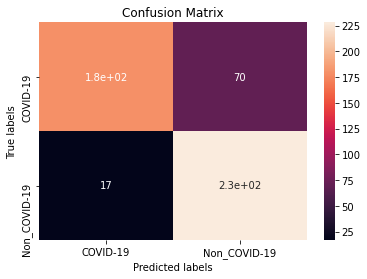

In [35]:
test_pred = top_model.predict(test_set,
                              steps=test_set.n,
                              use_multiprocessing=False,
                              verbose=1)

test_pred_class = (test_pred >= 0.5)*1

# Confusion Matrix
cm = confusion_matrix(test_set.classes,
                      test_pred_class)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COVID-19', 'Non_COVID-19']); ax.yaxis.set_ticklabels(['COVID-19', 'Non_COVID-19']);